In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import pyrepseq.plotting as pp

plt.style.use('bmh')

In [10]:
cpu = pd.read_csv('../data/cpu_benchmark.csv', index_col=0)
cpu = cpu[cpu['input_size']>100]
cpu.head()

,runtime,algorithm,input_size,distance
5,0.090237,kdtree,1000,1
6,0.491201,symspell,1000,1
7,0.379608,combinatorial_lookup,1000,1
8,0.302681,exhaustive_search,1000,1
9,0.121302,bktree,1000,1


In [11]:
gpu = pd.read_csv('../data/gpu_benchmark.csv', index_col=0)
gpu = gpu[gpu['input_size']>10000]
gpu.head()

,runtime,algorithm,input_size,distance
6,0.316787,V2,30000,1
7,0.219895,V1,30000,1
8,3.767601,symspell,30000,1
9,0.451551,V2,100000,1
10,0.247272,V1,100000,1


In [12]:
gpu['input_size'].value_counts()

30000       180
100000      180
300000      180
1000000     180
3000000     120
10000000    120
30000000     30
Name: input_size, dtype: int64

In [13]:
cpu_dist = pd.read_csv('../data/cpu_dist_benchmark.csv', index_col=0)
cpu_dist.head()

,runtime,algorithm,input_size,distance
0,6.329441,kdtree,10000,1
1,1.235529,symspell,10000,1
2,45.932961,exhaustive_search,10000,1
3,5.462839,bktree,10000,1
4,18.854132,kdtree,10000,2


In [17]:
algorithm_labels = {
                    'kdtree' : 'k-d tree bag',
                    'symspell' : 'SymDel lookup',
                    'combinatorial_lookup': 'Combinatorial lookup',
                    'exhaustive_search': 'Exhaustive search',
                    'bktree' : 'BKtree'
                   }
algorithm_labels2 = {
                    'symspell' : 'SymDel lookup (CPU)',
                    'V1' : 'XTNeigbor (GPU)',
                    'V2' : 'XTNeighbor-streaming (GPU)'
                   }
algorithms_cpu = ['exhaustive_search', 'bktree', 'combinatorial_lookup', 'kdtree', 'symspell']
algorithms_gpu = ['symspell', 'V1', 'V2']

cpu
exhaustive_search 1 2.11, 0.02
bktree 1 1.71, 0.01
combinatorial_lookup 1 1.02, 0.005
kdtree 1 1.71, 0.07
symspell 1 0.955, 0.03
exhaustive_search 2 2.11, 0.02
bktree 2 1.91, 0.01
combinatorial_lookup 2 0.998, 0e+00
kdtree 2 2.0, 0.04
symspell 2 1.08, 0.04
gpu
symspell 1 1.16, 0.01
V1 1 0.938, 0.02
V2 1 1.03, 0.03
symspell 2 1.16, 0.05
V1 2 0.75, 0.1
V2 2 1.36, 0.1


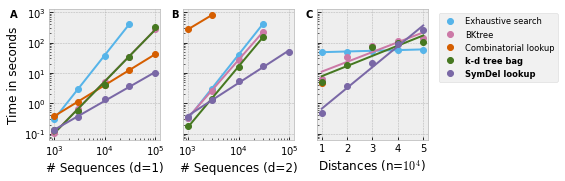

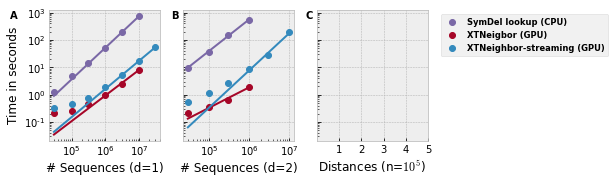

In [54]:
for name, df, algorithms, df2 in [('cpu', cpu, algorithms_cpu, cpu_dist), ('gpu', gpu, algorithms_gpu, None)]:
    print(name)
    fig, axes = plt.subplots(figsize=(6.8, 2.4), ncols=3, sharey=True, sharex=False)
    for d in [1, 2]:
        for index, algorithm in enumerate(algorithms):
            data = df[(df['distance']==d) & (df['algorithm']==algorithm)]
            mean = data.groupby('input_size').mean(numeric_only=True)
            x, y = mean.index, mean['runtime']
            if name == 'cpu':
                slope, intercept, r, p, se = scipy.stats.linregress(np.log(x), np.log(y))
                print(algorithm, d, f'{slope:.3}, {se:.1}')
                l, = axes[d-1].plot(x, y, 'o',
                        label=algorithm_labels[algorithm],#+'\n' + r'$\alpha =$'+f'{slope:.3}',
                        color=f'C{6-index}')
            if name == 'gpu':
                slope, intercept, r, p, se = scipy.stats.linregress(np.log(x[-3:]), np.log(y[-3:]))
                print(algorithm, d, f'{slope:.3}, {se:.1}')
                l, = axes[d-1].plot(x, y, 'o', label=algorithm_labels2[algorithm],#+'\n' + r'$\alpha =$'+f'{slope:.3}',
                                    color=f'C{2-index}')
            axes[d-1].plot(x, np.exp(slope*np.log(x)+intercept), '-', color=l.get_color())
            axes[d-1].set_xlabel('# Sequences (d='+str(d)+')')
        axes[d-1].set_yscale('log')
        axes[d-1].set_xscale('log')
        
    if name == 'cpu':                
        for index, algorithm in enumerate(algorithms):
            data2 = df2[df2['algorithm']==algorithm]
            mean2 = data2.groupby('distance').mean(numeric_only=True)
            x2, y2 = mean2.index, mean2['runtime']
            if algorithm != 'combinatorial_lookup':
                slope2, intercept2, r2, p, se = scipy.stats.linregress(x2, np.log(y2))
            l, = axes[2].plot(x2, y2, 'o', 
                    label=algorithm_labels[algorithm],#+'\n' + r2'$\alpha =$'+f'{slope2:.3}',
                    color=f'C{6-index}')
            axes[2].plot(x2, np.exp(slope2*x2+intercept2), '-', color=l.get_color())
        
    # draw d=1-5 graph
    
    axes[2].set_xticks([1,2,3,4,5])
    # axes[2].set_xlim([1,5])
    axes[2].set_xlabel('Distances (n=$10^'+(str(5) if name=='gpu' else str(4))+'$)')
    
    axes[0].set_ylabel('Time in seconds')
    legend = axes[-2].legend(bbox_to_anchor=(3.4 if name=="cpu" else 3.85, 1), fontsize='small')
    legend_texts = legend.get_texts()
    for i in range(1, 4 if name=='gpu' else 3):
        legend_texts[-i].set_weight('bold') 
    axes[0].text(-0.35, 1.0, 'A', transform=axes[0].transAxes, fontweight="bold", va="top")
    axes[1].text(-0.1, 1.0, 'B', transform=axes[1].transAxes, fontweight="bold", va="top")
    axes[2].text(-0.1, 1.0, 'C', transform=axes[2].transAxes, fontweight="bold", va="top")
    
    
    fig.savefig(f'{name}_benchmark2.pdf',bbox_inches='tight')
    # fig.savefig(f'{name}_benchmark.svg')